# Leveraging Entity Preposition for Financial Relation Extraction

This Jupyter Notebook builds the code for training a RoBERTa model on a public dataset, fine-tuning its parameters, and then making predictions on a private dataset. The model aims to perform Named Entity Recognition (NER), a crucial task in natural language processing.

Authors:
- Stefan Pasch
- Dimitrios Petridis


In [4]:
# Before starting executing the notebook, install the required packages:
!pip install -r requirements.txt

In [107]:
# Importing necessary libraries
# These libraries will help us process the data, train the model, and evaluate the performance:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from tqdm import tqdm
from scipy.special import softmax
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

In [25]:
# Utility functions:

def convert_to_list(value):
    """
    Function to convert a string representation of list to an actual Python list.
    If the conversion fails (in the case of an actual list being passed, or any other object),
    it returns the original input value.
    """
    try:
        return ast.literal_eval(value)
    except (SyntaxError, ValueError):
        return value


def create_input(token_list,
                 e1_start,
                 e2_start,
                 ner_list):
    """
    Function to create a clean text input for the model using the token list, the start position of each entity
    and the NER list.
    """
    output_text = ""
    for i in range(0, len(token_list)):
        if i == e1_start:
            text = str(ner_list[i]) + " " + str(token_list[i])
        elif i == e2_start:
            text = str(ner_list[i]) + " " + str(token_list[i])
        else:
            text = token_list[i]
        output_text = output_text + " " + text
    return output_text


# Mapping constants:

mapping = {
    "no_relation": 0,
    "org:date:formed_on": 1,
    "org:gpe:operations_in": 2,
    "pers:org:member_of": 3,
    "pers:org:employee_of": 4,
    "pers:gov_agy:member_of": 5,
    "org:org:acquired_by": 6,
    "org:money:loss_of": 7,
    "org:gpe:headquartered_in": 8,
    "pers:univ:employee_of": 9,
    "org:date:acquired_on": 10,
    "pers:univ:attended": 11,
    "org:gpe:formed_in": 12,
    "org:money:profit_of": 13,
    "org:money:cost_of": 14,
    "org:org:subsidiary_of": 15,
    "org:org:shares_of": 16,
    "pers:org:founder_of": 17,
    "pers:title:title": 18,
    "org:money:revenue_of": 19,
    "org:org:agreement_with": 20,
    "pers:univ:member_of": 21
}

mapping_reverse = { 
    0: "no_relation",
    1: "ORG-DATE",
    2: "ORG-GPE",
    3: "PERS-ORG",
    4: "PERS-ORG",
    5: "PERS-GOV_AGY",
    6: "ORG-ORG",
    7: "ORG-MONEY",
    8: "ORG-GPE",
    9: "PERS-UNIV",
    10: "ORG-DATE",
    11: "PERS-UNIV",
    12: "ORG-GPE",
    13: "ORG-MONEY",
    14: "ORG-MONEY",
    15: "ORG-ORG",
    16: "ORG-ORG",
    17: "PERS-ORG",
    18: "PERS-TITLE",
    19:"ORG-MONEY" ,
    20: "ORG-ORG",
    21: "PERS-UNIV"}

## Data Loading and Preprocessing

We first load the data and preprocess it for further analysis. We have four datasets which are traditionally used for the following porpuses:

1. Training Dataset: The model learns from this data.
2. Development (Dev) Dataset: Used to to fine-tune model parameters.
3. Testing Dataset: Used to evaluate the model's final performance.
4. Private Dataset: Unlabeled data for which we want the model to make predictions.

However, in our approach, we combine 1, 2 and 3 into one big training dataset.

The preprocessing includes conversion of the "spacy_ner" field to a list and creating clean text input for the model.


Continue,
by placing the public json datasets in the folder `data/public/`,<br>
and the private json dataset in the folder `data/private`.

In [7]:
tqdm.pandas()

# Function to preprocess datasets
def preprocess_data(df):
    # Convert the "spacy_ner" field into a list
    df['spacy_ner'] = df["spacy_ner"].apply(convert_to_list)
    # Create a clean input for the model using the token, ner_list, and the start position of each entity
    df["text"] = df.progress_apply(
        lambda row: create_input(token_list=row["token"],
                                 e1_start=row["e1_start"],
                                 e2_start=row["e2_start"],
                                 ner_list=row["spacy_ner"]),
        axis=1)
    # Map the "relation" field to a numerical "label" field
    df["label"] = df["relation"].map(mapping)
    # Remove any rows with missing labels
    df = df[df['label'].notna()]
    df.label = df.label.astype(int)
    return df


# Load datasets
train = pd.read_json("data/public/train_refind_official.json") # labeled
dev = pd.read_json("data/public/dev_refind_official.json") # labeled
test = pd.read_json("data/public/test_refind_official.json") # labeled
private = pd.read_json("data/private/private_dataset.json") # unlabeled


# Preprocess datasets
train = preprocess_data(train)
dev = preprocess_data(dev)
test = preprocess_data(test)

100%|██████████| 4300/4300 [00:00<00:00, 39953.63it/s]


In [8]:
# Confirm the conversion above:
[print(c['spacy_ner'].head(1)) for c in [train, dev, test, private]]

0    [O, O, O, ORG, ORG, ORG, O, O, O, ORG, ORG, OR...
Name: spacy_ner, dtype: object
0    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
Name: spacy_ner, dtype: object
0    [O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...
Name: spacy_ner, dtype: object
0    ['O', 'O', 'O', 'O', 'GOV_AGY', 'O', 'O', 'O',...
Name: spacy_ner, dtype: object


[None, None, None, None]

In [9]:
# For the private dataset, we don't have any labeled relation, hence we will fill the label column with zeros.

# Prepare the unlabeled (private) dataset separately:
private['spacy_ner'] = private["spacy_ner"].apply(convert_to_list)
private["text"] = private.progress_apply(
    lambda row: create_input(token_list=row["token"], e1_start=row["e1_start"], e2_start=row["e2_start"], ner_list=row["spacy_ner"]), axis=1)
private["label"] = 0
private = private[private['label'].notna()]
private.label = private.label.astype(int)


100%|██████████| 3069/3069 [00:00<00:00, 25844.76it/s]


## Dataset Preparation

Now that we've preprocessed the data, we'll select only the necessary columns in each dataset and check their lengths. Finally, we concatenate all labeled datasets to form a comprehensive training dataset.


In [10]:
# Function to format datasets
def format_data(df):
    # Keep only the "text" and "label" columns and reset the index
    df = df[["text", "label"]].reset_index(drop=True)
    return df

# Format datasets
train_df = format_data(train)
dev_df = format_data(dev)
test_df = format_data(test)
private_df = format_data(private)

# Print lengths of each dataset
print("Length of Train dataset:", len(train_df))
print("Length of Dev dataset:", len(dev_df))
print("Length of Test dataset:", len(test_df))
print("Length of Private dataset:", len(private_df))

# Concatenate all the labeled datasets together to one training dataset
all_train_df = pd.concat([train_df, dev_df, test_df])
print("Length of All Train dataset:", len(all_train_df))

# Check the labels distributions in the training dataset
label_distribution = all_train_df["label"].value_counts(normalize=True)
print(label_distribution)

Length of Train dataset: 20070
Length of Dev dataset: 4306
Length of Test dataset: 4300
Length of Private dataset: 3069
Length of All Train dataset: 28676
label
0     0.454945
18    0.155810
2     0.140989
4     0.086449
20    0.032606
1     0.022318
3     0.021970
15    0.019215
16    0.014228
19    0.010845
7     0.007044
8     0.006730
10    0.006486
17    0.004568
12    0.004010
6     0.002720
9     0.002650
5     0.001953
11    0.001500
21    0.001151
13    0.001011
14    0.000802
Name: proportion, dtype: float64


## Visualization of Label Distribution

Let's visualize the distribution of the labels in our comprehensive training dataset. This will help us understand the balance of labels in our data.

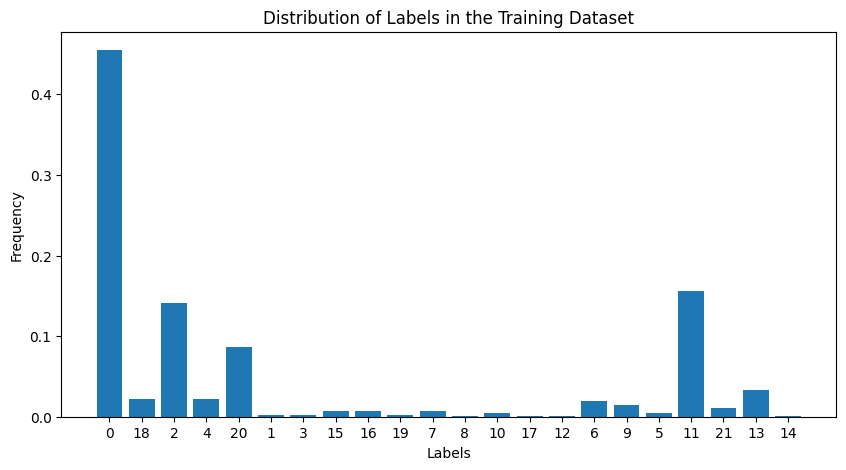

In [11]:
# Sort the distribution in descending order
sorted_label_distribution = label_distribution.sort_values(ascending=False)

# Create a figure and a bar plot
plt.figure(figsize=(10, 5))
plt.bar(sorted_label_distribution.index, sorted_label_distribution.values)

# Set xticks to have all labels
plt.xticks(np.arange(0, 22), sorted_label_distribution.index)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Dataset')

# Display the plot
plt.show()

In [12]:
# Check the structure of the training dataset:
all_train_df

,text,label
0,warrants to purchase ORG Lumos Networks Corp....,0
1,warrants to purchase ORG Lumos Networks Corp....,0
2,turn over to Global Gold at its offices in Ry...,0
3,ts Eighteen of FelCor Lodging LP Consolidated...,0
4,the ORG WFOE will waive and release you uncon...,0
...,...,...
4295,"In June 2015 , EchoStar purchased an equity i...",20
4296,"Future sales of ORG GERON CORP common stock ,...",20
4297,"Effective January 2012 , ORG Hughes Satellite...",20
4298,ORG Revlon Holdings agreed to indemnify ORG R...,20


## Dataset Conversion

To make the datasets compatible with Hugging Face's `Trainer`, we convert them into Dataset objects.

In [13]:
# Convert the datasets into "Trainer-able" Dataset objects:
all_train_dataset = Dataset.from_pandas(all_train_df)
private_dataset = Dataset.from_pandas(private_df)

In [14]:
# Check the structure of the converted training and private datasets:
print(all_train_dataset)
print(private_dataset)

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 28676
})
Dataset({
    features: ['text', 'label'],
    num_rows: 3069
})


## Tokenization

Finally, we'll create a tokenizer for the "roberta-large" model and tokenize our datasets. Tokenization is the process of converting text into a format that the model can understand.

In [15]:
# Create a tokenizer for the "roberta-large" model:
tokenizer = AutoTokenizer.from_pretrained("roberta-large")

# Function to tokenize the datasets:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

# Tokenize datasets:
all_train_tokenized = all_train_dataset.select(range(50)).map(tokenize_function, batched=True) # all_train_tokenized = all_train_dataset.map(tokenize_function, batched=True)
private_test_tokenized = private_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/3069 [00:00<?, ? examples/s]

## Training the RoBERTa model

Next, we are going to train our sequence classification model. The model we will be using is the `roberta-large` model. This is a large-sized variant of the RoBERTa model, which is itself a variant of the BERT model that uses a different training procedure.

In [16]:
model = AutoModelForSequenceClassification.from_pretrained("roberta-large", num_labels=22)

Some weights of the model checkpoint at roberta-large were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight']
You should 

Now, we set up our training arguments. We use the Trainer class from Hugging Face's Transformers library, which provides a wide range of customization options for training.

We'll train for 3 epochs with a learning rate of 1e-05, and a weight decay of 0.01.

We're also setting save_steps to 5000, which means the trainer will save a checkpoint every 5000 steps. This can be useful in case the training process gets interrupted, so we don't lose all our progress.

In [18]:
training_args = TrainingArguments("test_trainer",
                                  weight_decay=0.01,
                                  num_train_epochs=3.0,
                                  learning_rate=1e-05,
                                  save_steps=5000,
                                  per_device_train_batch_size=2) # per_device_train_batch=16

Now we instantiate the Trainer with our model, training arguments, and our tokenized datasets.

In [19]:
trainer = Trainer(
    model=model, args=training_args,
    train_dataset=all_train_tokenized,
    eval_dataset=private_test_tokenized
)

Finally, we train our model.

In [20]:
trainer.train()

/home/studio-lab-user/.conda/envs/dev_env/lib/python3.11/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss


TrainOutput(global_step=75, training_loss=1.0704501342773438, metrics={'train_runtime': 52.3316, 'train_samples_per_second': 2.866, 'train_steps_per_second': 1.433, 'total_flos': 139799150899200.0, 'train_loss': 1.0704501342773438, 'epoch': 3.0})

## Making Predictions

In [22]:
# Using the trainer to predict on our test dataset:
predict = trainer.predict(test_dataset = private_test_tokenized)

# Create an empty list to hold our predictions
liste = []

# For each prediction, find the index (class) with the highest score:
for i in predict[0]:
  max_val = -99
  for x in range(len(predict[0][1])):
    if i[x] > max_val:
      max_val = i[x]
      prediction = x
  liste.append(prediction)

# Adding our predictions to the private dataset:
private_df['prediction'] = liste

# Inspecting the first few rows of our dataset:
private_df.head()

,text,label,prediction
0,"Prior to entering the GOV_AGY Pentagon , Mr. ...",0,0
1,These actions will not result in ORG Ford Ind...,0,0
2,Interest Expense Interest expense increased f...,0,0
3,"aGvHD Phase 1 Trial In March 2021 , results w...",0,0
4,ROYALTY PHARMA PLC NOTES TO THE CONSOLIDATED ...,0,0


## Creating Output File
Now we will create the final output file which contains the prediction results. We will then import this file for further analysis.

In [33]:
# Isolating our predictions into a new DataFrame
output = private_df[['prediction']]

# Write to a CSV file
output.to_csv("data/output/predictions.csv",
              sep ='\t',
              header = False,
              index= False)

## Post-Processing Predictions

In [50]:
# Creating a DataFrame from the predictions:
df = pd.DataFrame(predict[0])

# Reading the original private dataset:
test = pd.read_json("data/private/private_dataset.json")

# Converting 'spacy_ner' column to list format:
test['spacy_ner'] = test["spacy_ner"].apply(convert_to_list)

# Merging the original data with our predictions:
test_merge = pd.merge(test, df, left_index=True, right_index=True)
test_merge["prediction"] = liste

test_merge["pred_relation"] = test_merge["prediction"].map(mapping_reverse)

# Creating the 'text' column by applying the 'create_input' function row-wise:
test_merge["text"] = test_merge.progress_apply(lambda row: create_input(token_list =row["token"],
                                                                        e1_start=row["e1_start"],
                                                                        e2_start = row["e2_start"],
                                                                        ner_list = row["spacy_ner"])
                                               , axis=1)

# Write to a CSV file:
test_merge.to_csv("data/output/predictions_merged.csv",
                  sep =';',
                  header = True)

test_merge.head()

100%|██████████| 3069/3069 [00:00<00:00, 25859.30it/s]


,id,docid,relation,rel_group,token,e1_start,e1_end,e2_start,e2_end,e1_type,...,15,16,17,18,19,20,21,prediction,pred_relation,text
0,1_William Cohen_30-32_Pentagon_4-5,2021,,PERSON-GOV_AGY,"[Prior, to, entering, the, Pentagon, ,, Mr., T...",30,32,4,5,PERSON,...,-0.390193,-0.533475,-0.328984,-0.532481,-1.139389,0.200098,-0.753552,0,no_relation,"Prior to entering the GOV_AGY Pentagon , Mr. ..."
1,267_Ford India_6-8_Sanand_25-26_6-8_25-26,2021,,ORG-GPE,"[These, actions, will, not, result, in, Ford, ...",6,8,25,26,ORG,...,-0.147122,-0.552815,0.070774,-0.730422,-0.791448,0.233352,-0.638023,0,no_relation,These actions will not result in ORG Ford Ind...
2,76_Ellie Mae_49-51_May 2020_31-33_49-51_31-33,2021,,ORG-DATE,"[Interest, Expense, Interest, expense, increas...",49,51,31,33,ORG,...,-0.013391,-0.642450,0.041890,-0.757049,-0.696738,0.219204,-0.649191,0,no_relation,Interest Expense Interest expense increased f...
3,326_Brian C. Betts_33-36_Investigator_13-14,2021,,PERSON-TITLE,"[aGvHD, Phase, 1, Trial, In, March, 2021, ,, r...",33,36,13,14,PERSON,...,-0.109742,-0.802094,-0.447290,-0.514643,-1.020846,0.373282,-0.827603,0,no_relation,"aGvHD Phase 1 Trial In March 2021 , results w..."
4,119_Gilead_49-50_2019_39-40_49-50_39-40,2021,,ORG-DATE,"[ROYALTY, PHARMA, PLC, NOTES, TO, THE, CONSOLI...",49,50,39,40,ORG,...,-0.338050,-0.686948,-0.484813,-0.525706,-1.151302,0.476228,-0.696910,0,no_relation,ROYALTY PHARMA PLC NOTES TO THE CONSOLIDATED ...


After inspecting the initial results, we notice some discrepancies between our predictions and the true labels. To tackle this, we implement an innovative strategy: for every incorrect prediction, we select the class with the second highest probability instead of the top one. Let's see how this affects our results.

In [59]:
# Add each class's probability to its own column in the DataFrame:
test_merge['rel_groups_vector'] = test_merge[[int(el) for el in list(np.arange(0,22))]].agg(np.array, axis=1)
test_merge['rel_groups_vector_softmax'] = test_merge['rel_groups_vector'].apply(softmax)
for i in range(22):
    test_merge[f'p_{i}'] = test_merge['rel_groups_vector_softmax'].apply(lambda x: pd.Series(x[i]))
test_merge["max_softmax"] = test_merge['rel_groups_vector_softmax'].apply(lambda x: max(x))

In [63]:
# Function to find the second largest number and its position:
def get_second_largest_and_position(lst):

    if len(lst) < 2:
        raise ValueError("List should have at least two elements.")
    largest = float('-inf')  # Initialize with negative infinity
    second_largest = float('-inf')  # Initialize with negative infinity
    largest_index = -1
    second_largest_index = -1

    for i, num in enumerate(lst):
        if num > largest:
            second_largest = largest
            second_largest_index = largest_index
            largest = num
            largest_index = i
        elif num > second_largest and num != largest:
            second_largest = num
            second_largest_index = i

    if second_largest_index == -1:
        raise ValueError("No second largest element found in the list.")

    return [second_largest, second_largest_index]

In [67]:
# Apply the function to the DataFrame:
test_merge["max_softmax_second"] = test_merge['rel_groups_vector_softmax'].apply(lambda x: get_second_largest_and_position(x))

In [71]:
# Mismatch function:
def mismatch(pred_group, initial_group):
  if (pred_group !=  initial_group) & (pred_group != "no_relation"):
    return 1
  else:
    return 0

In [72]:
# Apply mismatch function:
tqdm.pandas(desc="create clean input TEST")
test_merge["mismatch"] = test_merge.progress_apply(lambda row: mismatch(pred_group =row["pred_relation"],
                                                                        initial_group=row["rel_group"]), 
                                                   axis=1)

create clean input TEST: 100%|██████████| 3069/3069 [00:00<00:00, 95660.17it/s]


In [76]:
# Select the second highest probability relation when there is a group mismatch:
test_merge["corrected_final_prediction"] = test_merge.apply(lambda row: row['prediction'] if row['mismatch']==0 else row['max_softmax_second'][1], axis=1)

In [99]:
# Prepare the final output:
output = test_merge[['corrected_final_prediction']]

# Write to a CSV file:
output.to_csv("data/output/predictions_final.csv",
                  sep =';',
                  header = True)

In [111]:
# Print output DataFrame head:
output.head()

,corrected_final_prediction
0,0
1,0
2,0
3,0
4,0


## Visualizing the Results

We can now also plot the distribution of our preditions.

In [113]:
# Check the labels distributions in the predictions:
label_distribution = output["corrected_final_prediction"].value_counts(normalize=True)
print(label_distribution)

corrected_final_prediction
0    1.0
Name: proportion, dtype: float64


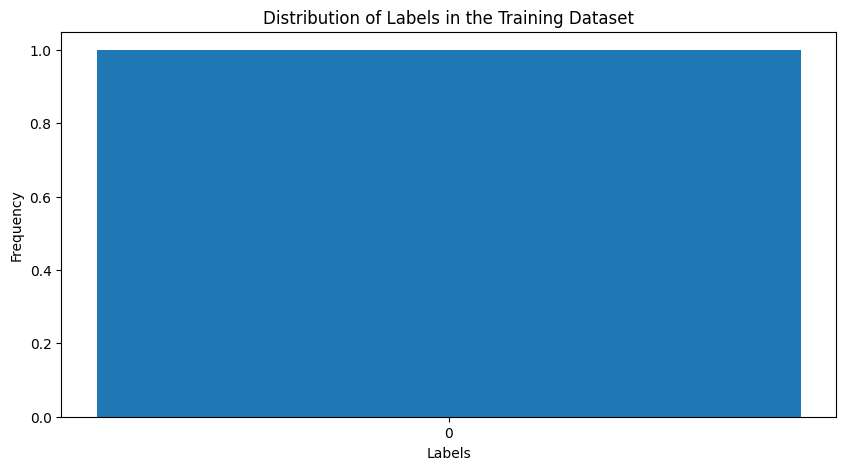

In [115]:
# Sort the distribution in descending order
sorted_label_distribution = label_distribution.sort_values(ascending=False)

# Create a figure and a bar plot
plt.figure(figsize=(10, 5))
plt.bar(sorted_label_distribution.index, sorted_label_distribution.values)

# Set xticks to have all labels
plt.xticks(np.arange(0, 1), sorted_label_distribution.index)

# Add labels and title
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.title('Distribution of Labels in the Training Dataset')

# Display the plot
plt.show()